In [70]:
"""
Imports
"""

import json
from copy import deepcopy
from typing import Iterable, Union
from enum import Enum, auto
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.github_graph import *
from src.db import db

In [71]:
"""
Load the graph into memory and print basic statistics
"""

graph = GitHubBipartiteGraph.from_database(db())

print(f"""\
  {len(graph.contributors):,} contributors
+ {len(graph.repositories):,} repositories
= {len(graph.contributors) + len(graph.repositories):,} nodes
""")
print(f"{len(graph.contributes_to):,} edges")

  347,255 contributors
+ 978 repositories
= 348,233 nodes

466,805 edges


In [72]:
"""
Make the graph easier to work with
"""

# some_user/their_project => Repository
repos: dict[str, Repository] = {f"{r.owner}/{r.project}": r for r in graph.repositories}

# {user emails}
users: set[str] = graph.contributors.copy()

# edges
repo_to_users: dict[Repository, dict[str, int]] = {}
user_to_repos: dict[str, dict[Repository, int]] = {}

rank_to_repo = {r.rank: r for r in graph.repositories}
for edge in graph.contributes_to:
    repo = rank_to_repo[edge.repository_rank]
    current_users = repo_to_users.get(repo, dict())
    current_users[edge.contributor_email] = edge.ncommits
    repo_to_users[repo] = current_users
    
    current_repos = user_to_repos.get(edge.contributor_email, dict())
    current_repos[repo] = edge.ncommits
    user_to_repos[edge.contributor_email] = current_repos

In [73]:
class DistributionMethod(Enum):
    COUNT = auto()
    PROPORTION = auto()

def cumulative_distribution(dist: Iterable[Union[int, float]], 
                            method: DistributionMethod=DistributionMethod.PROPORTION
                           ) -> Iterable[tuple[int, int]]:
    """
    Finds how many items are greater than or equal to each unique value in dist.

    Args:
        dist:   a distribution of numbers
        method: (optional) decides if the returned y values should be counts or propotions

    Returns:
        tuple x, y ready for plotting
    """
    cpy = list(dist).copy()
    cpy.sort()
    
    x = []
    y = []

    i = 0
    while i < len(cpy):
        val = cpy[i]
        num_val = 1
        while i+1 < len(cpy) and val == cpy[i+1]:
            i += 1
            num_val += 1
        i += 1

        x.append(val)
        y.append(len(cpy) - i + num_val)

    if method == DistributionMethod.PROPORTION:
        tot = sum(y)
        for i, val in enumerate(y):
            y[i] = val / tot
    elif method != DistributionMethod.COUNT:
        raise ValueError(f"Unrecognized method {method}")

    return x, y

In [74]:
FIG = Path("fig")
FIG.mkdir(exist_ok=True, parents=True)

def figure(filename: str):
    "saves and shows the figure"
    plt.savefig(FIG / filename)
    plt.show()
    plt.close()

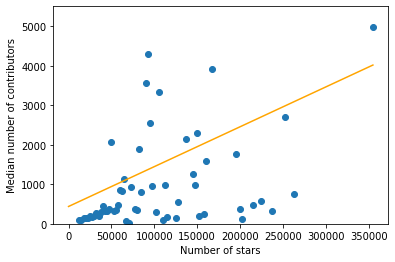

In [75]:
"""
How are # stars and # contributors related?
            x               y
"""
smoothing_factor = 2500

stars_to_contributors: dict[int, list[int]] = {}
for repo, users in repo_to_users.items():
    l = stars_to_contributors.get(repo.stars // smoothing_factor, list())
    l.append(len(users))
    stars_to_contributors[repo.stars // smoothing_factor] = l

x_series = []
y_series = []
for num_stars in sorted(stars_to_contributors.keys()):
    x_series.append(num_stars * smoothing_factor)
    l = sorted(stars_to_contributors[num_stars])
    y_series.append(l[len(l) // 2])

m, b = np.polyfit(x_series, y_series, 1)
plt.plot([0, x_series[-1]], [b, m*x_series[-1]+b], color="orange")
plt.scatter(x_series, y_series)
plt.ylim(0, 5500)
plt.xlabel("Number of stars")
plt.ylabel("Median number of contributors")
plt.savefig(FIG / "stars_to_contributors.pdf")
plt.show()


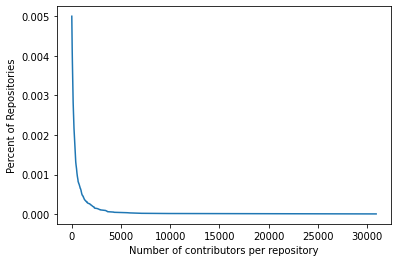

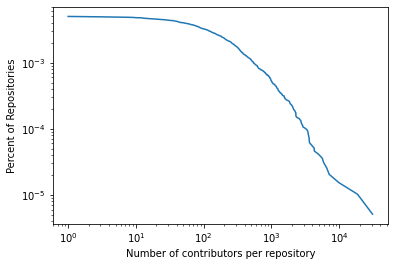

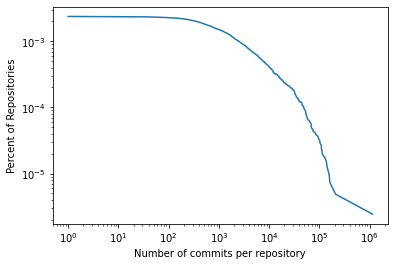

In [76]:
"""
How many contributors (& commits) does each repository have?
"""

num_contributors = [len(users) for users in repo_to_users.values()]

x, y = cumulative_distribution(num_contributors)
plt.plot(x, y)
plt.xlabel("Number of contributors per repository")
plt.ylabel("Percent of Repositories")
figure("num_contributors_nonlog.pdf")

plt.plot(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of contributors per repository")
plt.ylabel("Percent of Repositories")
figure("num_contributors_log.pdf")

num_commits = [sum(users.values()) for users in repo_to_users.values()]
x, y = cumulative_distribution(num_commits)
plt.plot(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of commits per repository")
plt.ylabel("Percent of Repositories")
figure("num_commits_log.pdf")

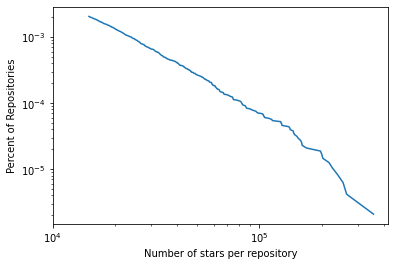

In [77]:
"""
How many stars does each repository have?
"""

num_stars = [r.stars for r in repos.values()]
x, y = cumulative_distribution(num_stars)
plt.plot(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of stars per repository")
plt.ylabel("Percent of Repositories")
plt.xticks([10**i for i in range(4, 6)])
figure("num_stars.pdf")

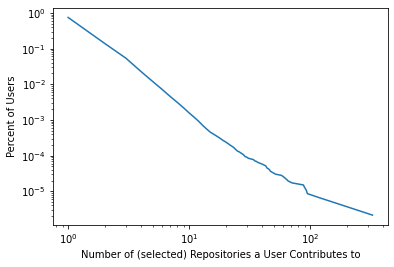

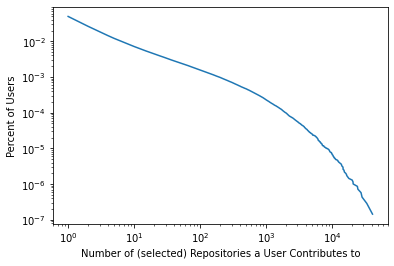

In [78]:
"""
How many commits has each user made? (to repositories in our list)
"""
num_repos_user_commits_to = [len(user.values()) for user in user_to_repos.values()]
x, y = cumulative_distribution(num_repos_user_commits_to)
plt.plot(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of (selected) Repositories a User Contributes to")
plt.ylabel("Percent of Users")
figure("num_repos_user_commits_to.pdf")

num_commits_per_user_to_any_tracked_repo = [sum(user.values()) for user in user_to_repos.values()]
x, y = cumulative_distribution(num_commits_per_user_to_any_tracked_repo)
plt.plot(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of (selected) Repositories a User Contributes to")
plt.ylabel("Percent of Users")
figure("num_commits_per_user_to_any_tracked_repo.pdf")

In [79]:
"""
Find the "open source superstars" who have at least n commits to any repository
"""
n = 1000

superstars = {user: sum(repos.values()) for (user, repos) in user_to_repos.items()
                                        if sum(repos.values()) > n}
g = deepcopy(graph)
g.contributors = set(c for c in g.contributors if c.email in superstars)
g.contributes_to = set(edge for edge in g.contributes_to if edge.contributor_email in superstars)
repo_ranks_with_superstars = set(edge.repository_rank for edge in g.contributes_to)
g.repositories = set(repo for repo in g.repositories if repo.rank in repo_ranks_with_superstars)

print(f"""\
  {len(g.contributors):,} contributors
+ {len(g.repositories):,} repositories
= {len(g.contributors) + len(g.repositories):,} nodes
""")
print(f"{len(g.contributes_to):,} edges")

with open("tmp/superstars.json", "w", encoding="utf-8") as handle:
    handle.write(g.to_json())

  1,604 contributors
+ 738 repositories
= 2,342 nodes

5,252 edges


In [80]:
"""
Repository analysis by projecting the bipartite graph onto the repositories.
Repositories A and B are linked if they share some contributor(s). Edge weight is the number of contributors they share.
"""

# (rank1, rank2) => num_users   ... rank1 < rank2
proj: dict[tuple[int, int], int] = {}
proj_repos = sorted(repos.values(), key=lambda r: r.rank)

for repo2 in tqdm(proj_repos):
    users2 = set(repo_to_users.get(repo2, {}).keys())
    for repo1 in proj_repos:
        if repo1.rank >= repo2.rank:
            break

        common_users = users2.intersection(repo_to_users[repo1].keys())
        if len(common_users) > 0:
            key = (repo1.rank, repo2.rank)
            proj[key] = proj.get(key, 0) + len(common_users)

100%|██████████| 978/978 [00:15<00:00, 65.11it/s] 


In [81]:
"""
Write json for Cytoscape import.
Filter edges for weight >= n.
"""
n = 25
filtered_proj_edes = {k: v for (k, v) in proj.items() if v >= n}

with open("tmp/repo_proj.json", "w", encoding="utf-8") as handle:
    json.dump({
        "elements": {
            "nodes": [
                *[
                    {
                        "data": {
                            "id": str(repo.rank),
                            "label": f"{repo.owner}/{repo.project}",
                            "type": "repository",
                            "owner": f"{repo.owner}",
                            "project": f"{repo.project}",
                            "stars": repo.stars,
                            "primary_language": max(repo.languages, key=lambda lang: repo.languages[lang]),
                            **repo.languages
                        }
                    } for repo in proj_repos
                ],
            ],
            "edges": [
                {
                    "data": {
                        "id": i,
                        "source": str(repo1),
                        "target": str(repo2),
                        "weight": common_users
                    }
                } for i, ((repo1, repo2), common_users) in enumerate(filtered_proj_edes.items())
            ]
        }
    }, handle, indent=2)

print(f"Nodes: {len(proj_repos)}")
print(f"Edges: {len(filtered_proj_edes)}")

Nodes: 978
Edges: 1170


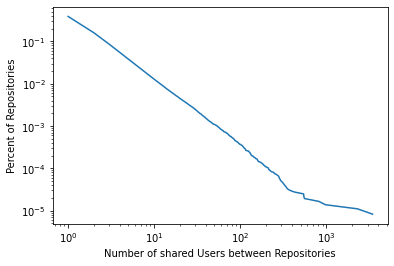

In [82]:
x, y = cumulative_distribution(proj.values())
plt.plot(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of shared Users between Repositories")
plt.ylabel("Percent of Repositories")
figure("repo_projection_degree_distribution.pdf")
